# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.01 # скорость обучения нейронной сети
training_steps = 5000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))
        
    def __call__(self, x):
        linear = tf.matmul(x, self.weights) + self.bias
        return tf.nn.sigmoid(linear)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)
        return tf.nn.softmax(x)

In [7]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


def accuracy(y_pred, y_true):
    correct_predictions = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [8]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(model, input_x, output_y):
    with tf.GradientTape() as tape:
        predictions = model(input_x)
        loss = cross_entropy(predictions, output_y)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer = tf.optimizers.Adam(learning_rate)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [9]:
# Тренировка сети

loss_history = [] 
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        
        loss_history.append(loss)
        accuracy_history.append(acc)
        
        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

Step 100, Loss: 1.5905325412750244, Accuracy: 0.92578125
Step 200, Loss: 1.5525541305541992, Accuracy: 0.9296875
Step 300, Loss: 1.533400535583496, Accuracy: 0.94140625
Step 400, Loss: 1.5483756065368652, Accuracy: 0.9609375
Step 500, Loss: 1.5287365913391113, Accuracy: 0.9375
Step 600, Loss: 1.5305719375610352, Accuracy: 0.9453125
Step 700, Loss: 1.4931306838989258, Accuracy: 0.9765625
Step 800, Loss: 1.5269370079040527, Accuracy: 0.95703125
Step 900, Loss: 1.512418508529663, Accuracy: 0.953125
Step 1000, Loss: 1.5174585580825806, Accuracy: 0.9453125
Step 1100, Loss: 1.5243189334869385, Accuracy: 0.94921875
Step 1200, Loss: 1.4972012042999268, Accuracy: 0.96875
Step 1300, Loss: 1.5046195983886719, Accuracy: 0.96875
Step 1400, Loss: 1.4988528490066528, Accuracy: 0.9765625
Step 1500, Loss: 1.4956319332122803, Accuracy: 0.96875
Step 1600, Loss: 1.4942562580108643, Accuracy: 0.9765625
Step 1700, Loss: 1.4894652366638184, Accuracy: 0.98046875
Step 1800, Loss: 1.4899944067001343, Accuracy: 

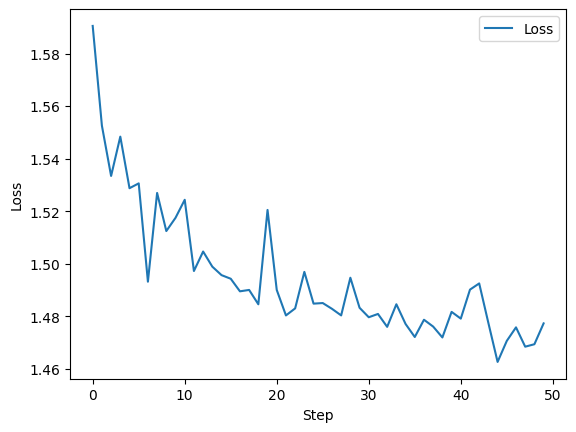

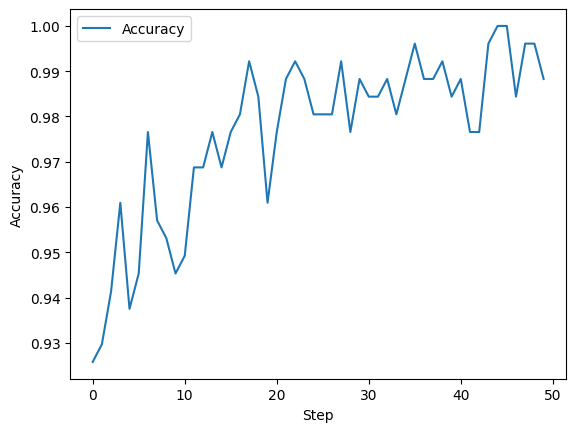

In [10]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Вычислите точность обученной нейросети
test_accuracy = []
for batch_x, batch_y in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size):
    batch_x = tf.cast(batch_x, tf.float32)
    batch_y = tf.cast(batch_y, tf.float32)
    pred = neural_net(batch_x)
    acc = accuracy(pred, batch_y)
    test_accuracy.append(acc)

average_test_accuracy = tf.reduce_mean(test_accuracy)
print(f'Точність на тестовій вибірці: {average_test_accuracy.numpy():.4f}')


Точність на тестовій вибірці: 0.9695


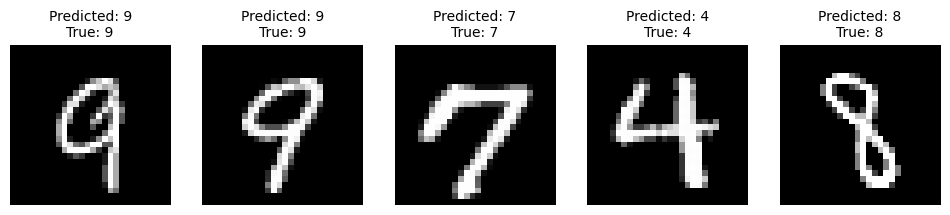

In [12]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
random_indices = np.random.choice(len(x_test), size=5, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

predictions = neural_net(images_to_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}\nTrue: {labels_to_test[i]}', fontsize=10)
    plt.axis('off')
plt.show()
